In [1]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import regex as re
from typing import List, Optional, Dict, Tuple
import time

import msgspec
from tqdm import tqdm
from loguru import logger
from dacite import from_dict
import dacite

from common.constants import SYSTEM_PROMPT_FPG, CORE_OPTIONS, BANNED_TOKENS
from common.utils import remove_comments, replace_sorry, replace_calc, remove_multiline_comments, remove_singleline_comments, parse_idents, normalize_spaces
from common.pantograph.dataclasses import ProblemGenerationProcess, ProblemGenerationStep, Variable, normalize_draft, replace_span, Goal, GoalState, ProblemGenerationStep, ProblemGenerationProcess, TacticDraft
from common.pantograph.server import PersistentServer, TacticFailure, ServerError
from agent.problem_generation import AutoregressiveProblemGenerationAgent

/home/ma-user/anaconda3/envs/default/lib/python3.11/site-packages/torch_npu/utils/collect_env.py:58: UserWarning: Warning: The /usr/local/Ascend/nnae/latest owner does not match the current owner.
  warnings.warn(f"Warning: The {path} owner does not match the current owner.")
/home/ma-user/anaconda3/envs/default/lib/python3.11/site-packages/torch_npu/utils/collect_env.py:58: UserWarning: Warning: The /usr/local/Ascend/nnae/8.2.RC1/ascend_nnae_install.info owner does not match the current owner.
  warnings.warn(f"Warning: The {path} owner does not match the current owner.")
/home/ma-user/anaconda3/envs/default/lib/python3.11/site-packages/torch_npu/__init__.py:289: UserWarning: On the interactive interface, the value of TASK_QUEUE_ENABLE is set to 0 by default.                      Do not set it to 1 to prevent some unknown errors
  warnings.warn("On the interactive interface, the value of TASK_QUEUE_ENABLE is set to 0 by default. \


In [2]:
bracket_pairings = {
    '(' : ')',
    '[' : ']',
    '{' : '}',
    '⦃' : '⦄'
}

def parse_variables(s : str) -> Tuple[str, str]:
    base = 0
    variables = []
    target = None
    while base < len(s):
        if s[base] in ['(', '[', '{', '⦃']:
            bracket_type = s[base]
            bracket_pairing = bracket_pairings[bracket_type]
        
            stack_cnt = 0
            start_end_positions = []

            for i, char in enumerate(s[base:]):
                if char == bracket_type:
                    if stack_cnt == 0:
                        start_position = i
                    stack_cnt += 1
                elif char == bracket_pairing:
                    if stack_cnt > 0:
                        stack_cnt -= 1
                        if stack_cnt == 0:
                            end_position = i
                            start_end_positions.append((start_position, end_position))
                            break
            
            start, end = start_end_positions[0]
            variables.append(s[base+start:base+end+1])
            base += i
        else:
            if s[base] == ',':
                target = s[base+1:].strip()
                break
            base += 1
    
    return variables, target

In [3]:
def print_xtuner_sample(data: list):
    if 'system' in data['conversation'][0].keys():
        print('<SYSTEM>')
        print(data['conversation'][0]['system'])
        print('</SYSTEM>')
    print('<INPUT>')
    print(data['conversation'][0]['input'])
    print('</INPUT>\n<OUTPUT>')
    print(data['conversation'][0]['output'])
    print('</OUTPUT>')


In [4]:
base_dir = '/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/deductive_transformation'
data = []

for i in tqdm(list(range(41))):
    with open(osp.join(base_dir, f'reassembled_fixed_chunk_{1024*i}.pkl'), 'rb') as f:
        data.extend(pickle.load(f))

100%|██████████| 41/41 [01:53<00:00,  2.77s/it]


In [5]:
data_parsed = [d for d in data if d is not None]
assert all('parse_result' in d.keys() for d in data_parsed)
print(len(data), len(data_parsed), len(data)-len(data_parsed))

41109 39840 1269


### Informalization

In [25]:
informalization = []

for d in data_parsed:
    u = d['parse_result']['units'][-1]
    if len(u['invocations'] or []) == 0 or 'deductive_steps' not in u.keys():
        continue
    formal_statement = u['formal_statement']
    load_header = u['load_header']
    variables = []
    if formal_statement.startswith('∀ '):
        context, target = parse_variables(formal_statement[len('∀ '):])
    else:
        target = formal_statement.strip()

    new_formal_statement = 'example\n' + (('\n'.join(context) + '\n') if len(context) > 0 else '') + ': ' + target + '\n:= sorry'

    informalization.append({k : v for (k, v) in d.items() if k != 'parse_result'} | {
        'formal_statement': new_formal_statement,
        'deductive_steps': '\n\n'.join(s[0] + s[1] for s in u['deductive_steps'])
    })

In [26]:
with open(osp.join('/cache/workspace/formal_problem_generation/data/Numina-Lean', 'data_parsed_stmt_w_dstesp.0825.jsonl'), 'w') as f:
    for d in informalization:
        f.write(json.dumps(d))

In [27]:
print(len(informalization))
informalization[0]

38718


{'uuid': '84f26e70-3dfd-589b-b7d0-7792576f0cc9',
 'problem': 'Given that the product \\( a \\cdot b \\cdot c = 1 \\), what is the value of the following expression?\n\n$$\n\\frac{a}{a b + a + 1} + \\frac{b}{b c + b + 1} + \\frac{c}{c a + c + 1}\n$$',
 'question_type': '',
 'answer': 'unknown',
 'author': 'human',
 'formal_statement': 'example\n(a b c : ℝ)\n(h : a * b * c = 1)\n(haux : 1 + a + a * b ≠ 0)\n: a / (a * b + a + 1) + b / (b * c + b + 1) + c / (c * a + c + 1) = 1\n:= sorry',
 'ground_truth_type': 'complete',
 'rl_data': {'n_correct_proofs': 0, 'n_proofs': 0, 'win_rate': 0.0},
 'source': 'unknown',
 'problem_type': 'Algebra',
 'exam': 'unknown',
 'formal_code': 'import Mathlib\n\n/- Given that the product \\( a \\cdot b \\cdot c = 1 \\), what is the value of the following expression?\n$$\n\\frac{a}{a b + a + 1} + \\frac{b}{b c + b + 1} + \\frac{c}{c a + c + 1}\n$$-/\ntheorem algebra_4013 {a b c : ℝ} (h : a * b * c = 1) (haux : 1 + a + a * b ≠ 0) :\n    a / (a * b + a + 1) + b 

In [20]:
print(informalization[0]['formal_statement'])

example
(a b c : ℝ)
(h : a * b * c = 1)
(haux : 1 + a + a * b ≠ 0)
: a / (a * b + a + 1) + b / (b * c + b + 1) + c / (c * a + c + 1) = 1
:= sorry


In [22]:
print(informalization[0]['deductive_steps'])

have : a * b * c ≠ 0 := by rw [h]; norm_num

have ha : a ≠ 0 := left_ne_zero_of_mul <| left_ne_zero_of_mul this

have hb : b ≠ 0 := right_ne_zero_of_mul <| left_ne_zero_of_mul this

have h: 
    a / (a * b + a + 1) + b / (b * c + b + 1) + c / (c * a + c + 1) = 1  := by {
  conv => lhs; lhs; rhs; rw [← mul_div_mul_left _ _ ha]
  
  conv => lhs; rhs; rw [← mul_div_mul_left _ _ (mul_ne_zero ha hb)]
  
  
  
  
  rw [show a * (b * c + b + 1) = a*b*c + a*b + a by ring]
  rw [show a*b*(c * a + c + 1) = a*b*c*a + a*b*c + a*b by ring]
  
  rw [h, one_mul]
  ring_nf
  
  rw [← add_mul]
  nth_rw 2 [← one_mul (1 + a + a * b)⁻¹]
  rw [← add_mul, show a * b + a + 1 = 1 + a + a * b by ring]
  exact mul_inv_cancel₀ haux
}

exact h


### Data Analysis

In [7]:
n_total_units = 0
n_transformed_units = 0
n_deductive_units = 0
n_reassembled_units = 0

transformed_units = []

for d in data_parsed:
    units = d['parse_result']['units']
    all_parsed_units = [i_u for i_u, u in enumerate(units) if len(u['invocations'] or []) > 0]
    transformed_units.extend([units[i_u] for i_u in all_parsed_units if 'deductive_steps' in units[i_u].keys()])

    n_total_units += len(all_parsed_units)

deductive_units = [u for u in transformed_units if 'generation_process' in u.keys()] # Successfully execited w/ `False` target
reassembled_units = [u for u in deductive_units if 'original_trajectory' in u['generation_process'].metainfo] # Successfully execited w/ `False` target
    

print(n_total_units, len(transformed_units), len(deductive_units), len(reassembled_units))

41543 40069 39980 39509


In [ ]:
# anonymous_name_cnt = C.Counter()
# submission_cnt = C.Counter()

# for d in data_parsed:
#     for u in d['parse_result']['units']:
#         if 'deductive_states' in u.keys():
#             init_state = u['deductive_states'][0]
#             assert len(init_state) == 1
#             # init_state = from_dict(Goal, init_state[0])
#             for v in init_state[0]['variables']:
#                 if '✝' in v['name']:
#                     anonymous_name_cnt[v['name']] += 1
#                     assert v['name'].replace('✝', '_') not in str(u['deductive_states'])
            
#             submission = u['deductive_steps'][-1][-1][len('exact '):].strip()
#             if ' ' in submission or '.' in submission:
#                 print(submission)
#                 raise
#             else:
#                 submission_cnt[submission] += 1

# for (i, d) in enumerate(data_parsed):
#     if r'''theorem number_theory_4780 {a b p x : ℕ} ''' in d['formal_statement']:
#         break
# print(i)
# print(d['formal_statement'])

for i, d in enumerate(data_parsed):
    units = d['parse_result']['units']
    for i_u, u in enumerate(units):
        if len(u['invocations'] or []) > 0:
            if 'deductive_steps' in u.keys() and 'generation_process' not in u.keys():
                raise

RuntimeError: No active exception to reraise

In [14]:
server = PersistentServer(
    max_count=64,
    is_state_based=True,
    tag='',
    _sync_init=False,
    imports=["Mathlib", "Aesop"],
    project_path='/home/ma-user/workspace/formal_problem_generation/formal_problem_generation/data/MiniF2F',
    core_options=CORE_OPTIONS,
    timeout=300,
)

In [15]:
superscript_to_digit = {
    '⁰': '0', '¹': '1', '²': '2', '³': '3', '⁴': '4',
    '⁵': '5', '⁶': '6', '⁷': '7', '⁸': '8', '⁹': '9'
}

subscript_to_digit = {
    '₀': '0', '₁': '1', '₂': '2', '₃': '3', '₄': '4',
    '₅': '5', '₆': '6', '₇': '7', '₈': '8', '₉': '9'
}

digit_to_superscript = {v: k for k, v in superscript_to_digit.items()}
digit_to_subscript = {v: k for k, v in subscript_to_digit.items()}

allowed_prefices = ['h', 'h_']

def generate_submission_name(name_list: List[str]) -> str:
    # Parse names
    numbers_existing = C.defaultdict(list)
    for n in name_list:
        for p in allowed_prefices:
            if n.startswith(p):
                num_str = n[len(p):]
                if num_str == '':
                    numbers_existing[-1].append((p, 'text'))
                elif all(c in superscript_to_digit for c in num_str):
                    num = int(''.join(superscript_to_digit[c] for c in num_str))
                    numbers_existing[num].append((p, 'sup'))
                elif all(c in subscript_to_digit for c in num_str):
                    num = int(''.join(subscript_to_digit[c] for c in num_str))
                    numbers_existing[num].append((p, 'sub'))
                elif all(c.isascii() and c.isdigit() for c in num_str):
                    num = int(num_str)
                    numbers_existing[num].append((p, 'text'))
                    
    if not numbers_existing:
        numbers_existing = C.defaultdict(list, {
            -1: [('h', 'text')]
        })
    # Generate new name
    max_number = sorted(numbers_existing.keys())[-1]
    number_chosen = max_number + 1
    prefix, format_type = random.choice(numbers_existing[max_number])
    
    if number_chosen == 0:
        formatted_num = ''
    else:
        num_str = str(number_chosen)
        if format_type == 'sup':
            formatted_num = ''.join(digit_to_superscript[c] for c in num_str)
        elif format_type == 'sub':
            formatted_num = ''.join(digit_to_subscript[c] for c in num_str)
        else:  # text
            formatted_num = num_str
    new_name = f"{prefix}{formatted_num}"
    logger.debug(f'numbers_existing={numbers_existing}, max_number={number_chosen}, new_name={new_name}')
    return new_name

In [ ]:
datapoint = d
base_cnt = 0
idx = 0
i_p = 0

In [17]:
import_list = datapoint['parse_result']['import_list']
open_scoped_list = datapoint['parse_result']['open_scoped_list']
open_list = datapoint['parse_result']['open_list']
option_list = datapoint['parse_result']['option_list']
units = datapoint['parse_result']['units']

all_transformed_units = [i_u for i_u, u in enumerate(units) if 'deductive_steps' in units[i_u].keys()]
remaining_units = [i_u for i_u in all_transformed_units if 'generation_process' not in units[i_u].keys()]
logger.debug(f'async_worker({base_cnt+idx}): {len(remaining_units)}/{len(all_transformed_units)} units to reasseblme')
if len(remaining_units) == 0:
    raise

tactic_header = ''
load_header = ''
if len(open_scoped_list):
    tactic_header += 'open scoped ' + ' '.join(t for t in open_scoped_list) + ' in\n'
    load_header += 'open scoped ' + ' '.join(t for t in open_scoped_list) + '\n'
if len(open_list):
    tactic_header += 'open ' + ' '.join(t for t in open_list) + ' in\n'
    load_header += 'open ' + ' '.join(t for t in open_list) + '\n'
if len(option_list):
    tactic_header += '\n'.join('set_option ' + t + ' in' for t in option_list) + '\n'
    load_header += '\n'.join('set_option ' + t for t in option_list) + '\n'

# II. Reassemble trajectories
agent = AutoregressiveProblemGenerationAgent(0)

2025-08-21 11:48:27.483 | DEBUG    | __main__:<module>:9 - async_worker(0): 1/1 units to reasseblme


In [18]:
u = units[remaining_units[0]]

In [31]:
deductive_steps: List[Tuple[str, str]] = u['deductive_steps']
deductive_states: List[List[Dict]] = u['deductive_states']
if len(deductive_states[-1]) != 0:  #* Caused by a bug in `numina-lean.deductive_transform-decompose.py` (fixed in `e657161`)
    for i in reversed(list(range(1, len(deductive_states)))):
        if deductive_states[i] == deductive_states[i-1]:
            break
    if deductive_states[i] == deductive_states[i-1]:
        logger.debug(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Removing {i}-th state (duplicated)')
        deductive_states.pop(i)
    deductive_states.append([])
if len(deductive_steps) + 1 != len(deductive_states):
    logger.warning(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): len(deductive_steps) + 1 != len(deductive_states): {len(deductive_steps)}, {len(deductive_states)}')

states: List[GoalState] = []
steps: List[ProblemGenerationStep] = []
cur_problem_state = await server.load_statement_async('False')
states.append(cur_problem_state)

# Execute introducing steps
assert len(deductive_states[0]) == 1

init_parsed_goal = dacite.from_dict(Goal, deductive_states[0][0])
var_type_dict = {
    v.name : v.t for v in init_parsed_goal.variables
}
var_value_dict = {
    v.name : v.v for v in init_parsed_goal.variables
}

# Break from formal statement
formal_statement = u['formal_statement']
variables = []
if formal_statement.startswith('∀ '):
    context, target = parse_variables(formal_statement[len('∀ '):])
    for declaration in context:
        if declaration[0] == '[':
            try:
                var_names, var_type = declaration[1:-1].split(':', 1)
            except ValueError:
                var_names = '_'
                var_type = declaration[1:-1]
            for name in var_names.strip().split():
                print(name, var_type)
                variables.append((name.strip(), var_type))
        else:
            assert '✝' not in declaration, f'declaration: {declaration}'
            try:
                var_names, var_type = declaration[1:-1].split(':', 1)
            except ValueError:
                var_names = declaration[1:-1]
                var_type = None
            for name in var_names.strip().split():
                if '✝' in name:
                    logger.critical(f"async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): '✝' in name: {[formal_statement]}")
                    name = '_'
                variables.append((name.strip(), var_type or var_type_dict[name.strip()]))
else:
    target = formal_statement.strip()

for (name, var_type) in variables:
    # name = v.name
    # decl = v.t
    # if '✝' in v.name:
    #     assert v.name.replace('✝', '_') not in str(u['deductive_states'])
    #     name = v.name.replace('✝', '_')
    # if decl.startswith('Type u_'):
    #     decl = 'Type*'
    # elif decl.startswith('Sort u*'):
    #     decl = 'Sort*'
    cur_step = ProblemGenerationStep(   # ProblemGenerationStepCategory.Introduce
        step_draft=f'have {name} : {var_type} := sorry', # if var_value_dict[name] is None else f'let {name} : {var_type} := {var_value_dict[name]}'
        proof=None,
        new_contexts=[]
    )
    
    try:
        new_problem_state = await server.goal_tactic_async(cur_problem_state, 0, cur_step.step)
    except (TacticFailure, ServerError):
        cur_step.step_draft = tactic_header + cur_step.step_draft
        new_problem_state = await server.goal_tactic_async(cur_problem_state, 0, cur_step.step)
    assert len(new_problem_state.goals) == 1 and new_problem_state.goals[0].target == 'False', str(new_problem_state)
    idents = set(cur_step.step.split())
    for banned_token in BANNED_TOKENS[1:]:
        if banned_token in idents:
            logger.critical(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Banned token "{banned_token}" in step "{step_code}"')
    
    cur_step.new_contexts = [
        v for v in new_problem_state.goals[0].variables if
            v.raw_name not in {vv.raw_name for vv in cur_problem_state.goals[0].variables}
            # v not in forward_state.goals[0].variables
    ]
    if len(cur_step.new_contexts) != 1:
        logger.critical(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Strange introducing step: {str(cur_step)}')
    
    states.append(new_problem_state)
    steps.append(cur_step)
    cur_problem_state = new_problem_state

if init_parsed_goal.variables != cur_problem_state.goals[0].variables:
    logger.debug(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): init_parsed_goal.variables != cur_problem_state.goals[0].variables: {[str(init_parsed_goal), str(cur_problem_state.goals[0])]}')


2025-08-21 11:56:25.752 | WARNING  | __main__:<module>:12 - async_worker(0-0/1): len(deductive_steps) + 1 != len(deductive_states): 8, 8


In [32]:
# for s in deductive_states:
#     assert len(s) <= 1
#     print('---\n' + '\n'.join(str(dacite.from_dict(Goal, g)) for g in s) + '\n---\n\n')

In [33]:
print(cur_problem_state)
print(len(steps), len(states))

a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
⊢ False
7 8


In [34]:
# Execute deriving steps
for ((step_header, step_code), next_parsed_state) in zip(deductive_steps[:-1], deductive_states[1:-1]):
    assert len(next_parsed_state) == 1
    next_parsed_goal = dacite.from_dict(Goal, next_parsed_state[0])
    cur_step = ProblemGenerationStep(   # ProblemGenerationStepCategory.Derive
        step_draft=step_header + step_code,
        proof=[],
        new_contexts=[]
    )
    
    new_problem_state = await server.goal_tactic_async(cur_problem_state, 0, cur_step.step)
    assert len(new_problem_state.goals) == 1 and new_problem_state.goals[0].target == 'False', str(new_problem_state)
    idents = set(cur_step.step.split())
    for banned_token in BANNED_TOKENS:
        if banned_token in idents:
            logger.critical(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Banned token "{banned_token}" in step "{step_code}"')
            
    cur_step.new_contexts = [
        v for v in new_problem_state.goals[0].variables if
            v.raw_name not in {vv.raw_name for vv in cur_problem_state.goals[0].variables}
            # v not in forward_state.goals[0].variables
    ]
    if len(cur_step.new_contexts) == 0:
        logger.debug(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Unused step: {str(cur_step)}')
    
    print(cur_step.step)
    print('\n')
    print(new_problem_state)
    print('\n---\n')
    states.append(new_problem_state)
    steps.append(cur_step)
    cur_problem_state = new_problem_state

    if next_parsed_goal.variables != cur_problem_state.goals[0].variables:
        logger.debug(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): next_parsed_goal.variables != cur_problem_state.goals[0].variables: {[str(next_parsed_goal), str(cur_problem_state.goals[0])]}')


haveI := Nat.Prime.two_le hp


a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this : 2 ≤ p
⊢ False

---

haveI := Fact.mk hp


a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this✝ : 2 ≤ p
this : Fact (Nat.Prime p)
⊢ False

---



2025-08-21 11:56:57.418 | DEBUG    | __main__:<module>:24 - async_worker(0-0/1): Unused step: Derive
```lean4
push_cast at hfermat
```

2025-08-21 11:56:57.419 | DEBUG    | __main__:<module>:35 - async_worker(0-0/1): next_parsed_goal.variables != cur_problem_state.goals[0].variables: ['a b p x : ℕ\nhp : Nat.Prime p\nhpa : ¬p ∣ a\nhaxb : a * x ≡ b [MOD p]\nthis✝ : 2 ≤ p\nthis : Fact (Nat.Prime p)\nha : ↑a ≠ 0\nhfermat : ↑a ^ (p - 2) * ↑a = 1\n⊢ x ≡ a ^ (p - 2) * b [MOD p]', 'a b p x : ℕ\nhp : Nat.Prime p\nhpa : ¬p ∣ a\nhaxb : a * x ≡ b [MOD p]\nthis✝ : 2 ≤ p\nthis : Fact (Nat.Prime p)\nha : ↑a ≠ 0\nhfermat : ↑a ^ (p - 1) = 1\n⊢ False']


have ha : (a : ZMod p) ≠ 0 := fun h =>
  by
  rw [show (0 : ZMod p) = Nat.cast 0 by norm_cast, ZMod.eq_iff_modEq_nat, Nat.modEq_zero_iff_dvd] at h
  contradiction


a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this✝ : 2 ≤ p
this : Fact (Nat.Prime p)
ha : ↑a ≠ 0
⊢ False

---

have hfermat := ZMod.pow_card_sub_one_eq_one ha


a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this✝ : 2 ≤ p
this : Fact (Nat.Prime p)
ha : ↑a ≠ 0
hfermat : ↑a ^ (p - 1) = 1
⊢ False

---

push_cast at hfermat


a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this✝ : 2 ≤ p
this : Fact (Nat.Prime p)
ha : ↑a ≠ 0
hfermat : ↑a ^ (p - 1) = 1
⊢ False

---



2025-08-21 11:56:57.508 | DEBUG    | __main__:<module>:35 - async_worker(0-0/1): next_parsed_goal.variables != cur_problem_state.goals[0].variables: ['a b p x : ℕ\nhp : Nat.Prime p\nhpa : ¬p ∣ a\nhaxb : a * x ≡ b [MOD p]\nthis✝ : 2 ≤ p\nthis : Fact (Nat.Prime p)\nha : ↑a ≠ 0\nhfermat : ↑a ^ (p - 2) * ↑a = 1\nh : x ≡ a ^ (p - 2) * b [MOD p]\n⊢ x ≡ a ^ (p - 2) * b [MOD p]', 'a b p x : ℕ\nhp : Nat.Prime p\nhpa : ¬p ∣ a\nhaxb : a * x ≡ b [MOD p]\nthis✝ : 2 ≤ p\nthis : Fact (Nat.Prime p)\nha : ↑a ≠ 0\nhfermat : ↑a ^ (p - 2) * ↑a = 1\n⊢ False']


rw [show p - 1 = p - 2 + 1 by omega, pow_succ] at hfermat


a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this✝ : 2 ≤ p
this : Fact (Nat.Prime p)
ha : ↑a ≠ 0
hfermat : ↑a ^ (p - 2) * ↑a = 1
⊢ False

---



In [37]:
print(deductive_steps[-2][-1])

have h: 
    x ≡ a^(p-2)*b [MOD p]  := by {
  rw [← ZMod.eq_iff_modEq_nat] at haxb ⊢
  push_cast at haxb ⊢
  



  apply_fun ((a : ZMod p)^(p - 2) * ·) at haxb








  rwa [← mul_assoc, hfermat, one_mul] at haxb
}


In [29]:
# Execute submitting step
assert len(deductive_states[-1]) == 0
step_code = remove_comments(deductive_steps[-1][-1]).strip()
assert step_code.startswith('exact '), step_code
submission_name = step_code[len('exact '):]

if ' ' in submission_name or '.' in submission_name:
    new_name = generate_submission_name([v.name for v in cur_problem_state.goals[0].variables if v.name is not None])
    cur_step = ProblemGenerationStep(   # ProblemGenerationStepCategory.Derive
        step_draft=f'have {new_name} : {init_parsed_goal.target} := {submission_name}',
        proof=[],
        new_contexts=[]
    )
    submission_name = new_name
    
    try:
        new_problem_state = await server.goal_tactic_async(cur_problem_state, 0, cur_step.step)
    except (TacticFailure, ServerError):
        cur_step.step_draft = tactic_header + cur_step.step_draft
        new_problem_state = await server.goal_tactic_async(cur_problem_state, 0, cur_step.step)
    assert len(new_problem_state.goals) == 1 and new_problem_state.goals[0].target == 'False', str(new_problem_state)
    idents = set(cur_step.step.split())
    for banned_token in BANNED_TOKENS:
        if banned_token in idents:
            logger.critical(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Banned token "{banned_token}" in step "{step_code}"')
    
    cur_step.new_contexts = [
        v for v in new_problem_state.goals[0].variables if
            v.raw_name not in {vv.raw_name for vv in cur_problem_state.goals[0].variables}
            # v not in forward_state.goals[0].variables
    ]
    if len(cur_step.new_contexts) == 0:
        logger.warning(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): Unused step: {str(cur_step)}')
    
    states.append(new_problem_state)
    steps.append(cur_step)
    cur_problem_state = new_problem_state

assert submission_name in [v.name for v in cur_problem_state.goals[0].variables], f'submission_name={submission_name}, cur_problem_state={cur_problem_state}'
steps.append(
    ProblemGenerationStep(   # ProblemGenerationStepCategory.Submit
        step_draft=f'submit_answer {submission_name}',
        proof=None,
        new_contexts=None
    )
)

# Parsed trajectory
result = ProblemGenerationProcess(
    informal_problem='',
    informal_answer='',
    informal_solution='',
    header=None,
    formal_statement='',
    formal_solution_draft='',
    formal_proofs='',
    steps=steps,
    dependencies=[],
    trajectory=[(S.goals[0].variables, i) for i, S in enumerate(states)],
    metainfo=dict()
)

AssertionError: submission_name=h, cur_problem_state=a b p x : ℕ
hp : Nat.Prime p
hpa : ¬p ∣ a
haxb : a * x ≡ b [MOD p]
this✝ : 2 ≤ p
this : Fact (Nat.Prime p)
ha : ↑a ≠ 0
hfermat : ↑a ^ (p - 2) * ↑a = 1
⊢ False

In [16]:
print(cur_problem_state)

x y : ℝ
hx : x < 0
hy✝ : y < 0
h1 : |y| = 6
h2 : √((x - 8) ^ 2 + (y - 3) ^ 2) = 15
n : ℕ
hn : n > 0
h3 : √(x ^ 2 + y ^ 2) = √↑n
this✝ : (x - 8) ^ 2 + (y - 3) ^ 2 = ↑(15 ^ 2)
hy : y = -6
this : x ^ 2 + y ^ 2 = 52
eq : 52 = n
h4 : n = 52
⊢ False


In [17]:
steps[-2]

ProblemGenerationStep(step_draft='have h4 : n = 52 := eq.symm', proof=[], new_contexts=[Variable(t='n = 52', v=None, name='h4')])

In [18]:
steps[-1]

ProblemGenerationStep(step_draft='submit_answer h4', proof=None, new_contexts=None)

In [19]:
len(states), len(steps)

(19, 19)

In [20]:
# Reassemble trajectory
is_analyzed = await agent.analyze_async(
    result=result,
    states=states,
    server=server,
    tag=str(base_cnt+idx),
    reassemble_trajectory=True
)


In [21]:
is_analyzed

True

In [22]:
result.metainfo = json.dumps(result.metainfo | {'time_consumption': time.time() - time_start})

u['generation_process'] = result
logger.debug(f'async_worker({base_cnt+idx}-{i_p}/{len(remaining_units)}): succeeded.')

NameError: name 'time_start' is not defined

### Data Composition - Deductive Proof Generation

In [6]:
proof_lengths = []
for d in data_parsed:
    for u in d['parse_result']['units']:
        if 'deductive_steps' in u.keys():
            assert len(u['invocations'] or []) > 0
            proof_lengths.append(len(u['deductive_steps']))

In [7]:
C.Counter(proof_lengths)

Counter({2: 18721,
         3: 4766,
         4: 3252,
         5: 2733,
         6: 2398,
         7: 1781,
         8: 1504,
         9: 1065,
         10: 919,
         11: 681,
         12: 549,
         13: 359,
         14: 292,
         15: 216,
         16: 166,
         17: 148,
         18: 93,
         19: 75,
         20: 60,
         22: 43,
         21: 38,
         23: 36,
         24: 31,
         27: 21,
         26: 21,
         25: 15,
         28: 9,
         32: 9,
         29: 7,
         36: 6,
         34: 6,
         44: 5,
         39: 5,
         30: 5,
         1: 5,
         33: 4,
         37: 3,
         35: 3,
         42: 2,
         55: 2,
         40: 2,
         31: 2,
         49: 2,
         52: 2,
         53: 1,
         51: 1,
         77: 1,
         54: 1,
         38: 1,
         46: 1,
         65: 1})

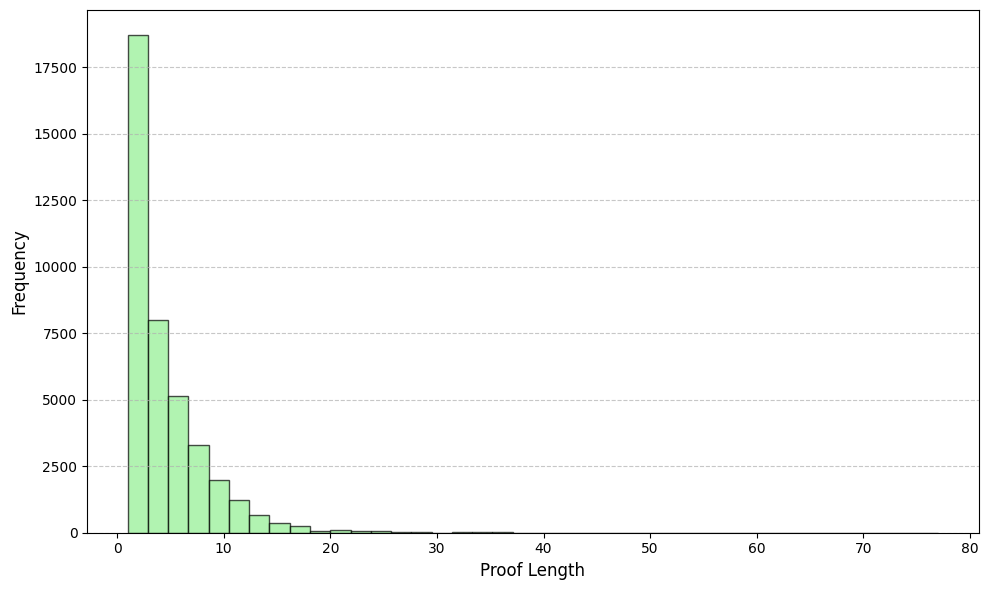

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# bins: Number of intervals to group integers (adjust based on your data range)
plt.hist(proof_lengths, bins=40, color='lightgreen', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Proof Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [9]:
data_deductive_proof_generation = []

In [10]:
header = ("""
import Mathlib
import Aesop

""" + '\n'.join('set_option ' + t.replace('=', ' ') for t in CORE_OPTIONS)).strip()
print(header)

import Mathlib
import Aesop

set_option maxHeartbeats 0
set_option maxRecDepth 100000
set_option tactic.hygienic false
set_option pp.fullNames true
set_option pp.funBinderTypes true
set_option pp.piBinderTypes true


In [11]:
for d in data_parsed:
    for u in d['parse_result']['units']:
        if 'deductive_steps' in u.keys():
            assert len(u['invocations'] or []) > 0
            
            init_state = u['deductive_states'][0]
            assert len(init_state) == 1
            init_state = from_dict(Goal, init_state[0])
            
            whole_proof = u['whole_proof']
            if whole_proof is None:
                # There is only one `whole_proof is None`, and is manually validated by Qi
                whole_proof = ''
                for t, s in u['deductive_steps']:
                    if len(t) > 0:
                        whole_proof += t
                    whole_proof += s + '\n\n'
                whole_proof = whole_proof.strip()
            
            data_deductive_proof_generation.append({
                "conversation":[
                    {
                        "input": f"""
Assume the following header is executed:
```lean4
{header}
```

Generate a deductive proof for the following Lean 4 proof state:
```lean4
{str(init_state)}
```
""".strip(),
                        "output": f'''
# Deductive Proof
```lean4
{whole_proof}
```
'''.strip()
                    }
                ]
            })

In [12]:
print_xtuner_sample(random.choice(data_deductive_proof_generation))

<INPUT>
Assume the following header is executed:
```lean4
import Mathlib
import Aesop

set_option maxHeartbeats 0
set_option maxRecDepth 100000
set_option tactic.hygienic false
set_option pp.fullNames true
set_option pp.funBinderTypes true
set_option pp.piBinderTypes true
```

Generate a deductive proof for the following Lean 4 proof state:
```lean4
⊢ {n : ℕ | 0 < n ∧ IsSquare (n ^ 2 + 19 * n + 130)} = {3, 30} ∧ ∑ x ∈ {3, 30}, x = 33
```
</INPUT>
<OUTPUT>
# Deductive Proof
```lean4
let S := {n : ℕ | 0 < n ∧ (IsSquare (n ^ 2 + 19 * n + 130))}

have hS : S = { 3, 30 } := by
  ext n
  constructor
  intro hn
  simp [S] at hn
  obtain ⟨npos, hn⟩ := hn
  obtain ⟨k, hk⟩ := hn
  simp
  have lb : (n + 9) ^ 2 < n ^ 2 + 19 * n + 130 := by nlinarith
  have ub : n ^ 2 + 19 * n + 130 < (n + 12) ^ 2 := by nlinarith
  have lbk : (n + 9) < k := by nlinarith
  have ubk : k < n + 12 := by nlinarith
  by_cases ke10 : k = n + 10
  rw [ke10] at hk
  rify at hk
  ring_nf at hk
  field_simp at hk
  have : (n 

In [15]:
with open('/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/deductive_proof_generation.40069.jsonl', 'w') as f:
    for d in data_deductive_proof_generation:
        f.write(json.dumps(d) + '\n')

### Data Composition - Autoregressive Problem Generation

In [15]:
def format_forward_solution_step_prompt(datapoint: Dict, introduced_fvars: List[str], state: List[Variable]) -> str:
    context = ''
    vars_to_format = [v for v in state]
    while len(vars_to_format) > 0:
        for i in range(len(vars_to_format)):
            if i + 1 == len(vars_to_format) or not (vars_to_format[i].t == vars_to_format[i+1].t and vars_to_format[i].v is None and vars_to_format[i+1].v is None):
                break
        if i == 0:
            context += str(vars_to_format[0]) + '\n'
            vars_to_format.pop(0)
        else:
            context += ' '.join([v.name if v.name is not None else "_" for v in vars_to_format[:i+1]]) + f' : {vars_to_format[0].t}\n'
            vars_to_format = vars_to_format[i+1:]
    
    introduced_fvars = '\n'.join(introduced_fvars)
    prompt = f'''Given the introduced variables/hypotheses and the current context in Lean 4, propose the single most natural next step to explore toward a beautiful conclusion — either
- derive a new intermediate fact,
- introduce a fresh variable or hypothesis, or
- submit one of the local facts as the final answer.

Requirements
1. Flavoured "{datapoint['problem_type']}" and suitable for posting on forums about "{datapoint['source']}".
2. Fully formal Lean 4 code (inline comments in natural language are fine for planning and reasoning). Assume `import Mathlib`.

# Introduced Variables/Hypotheses
```lean4
{introduced_fvars}
```

# Lean 4 Context
```lean4
{context.rstrip()}
```
'''.strip()
    return prompt

def format_step(self):
    if self.proof is None:
        return self.step_draft  # Here do not remove comment
    else:
        normalized_step_draft = normalize_draft(self.step_draft)
        matches = list(re.finditer(':= sorry', normalized_step_draft))
        assert len(matches) == len(self.proof)
        for (m, p) in reversed(list(zip(matches, self.proof))):
            normalized_step_draft = replace_span(m.span(), ':= by {\n' + '\n'.join('  ' + l for l in p.splitlines()) + '\n}', normalized_step_draft)
        return normalized_step_draft

def format_forward_solution_step_response(step: ProblemGenerationStep):
    step_type = 'Derive' if step.is_deducing else 'Introduce' if step.is_introducing else 'Submit'
    response = f'''# Step {step_type}
```lean4
{format_step(step).rstrip()}
```
'''.strip()
    return response

print(SYSTEM_PROMPT_FPG)

You are an Olympiad problem setter and a Lean 4 expert.
You revel in conjuring elegant problems — starting from a spare set of hypotheses, you let rigorous deduction lead you to surprising and beautiful conclusions.


In [16]:
n_total_units = 0
n_transformed_units = 0
n_deductive_units = 0
n_reassembled_units = 0

transformed_units = []

for d in data_parsed:
    units = d['parse_result']['units']
    all_parsed_units = [i_u for i_u, u in enumerate(units) if len(u['invocations'] or []) > 0]
    transformed_units.extend([(d, units[i_u]) for i_u in all_parsed_units if 'deductive_steps' in units[i_u].keys()])

    n_total_units += len(all_parsed_units)

deductive_units = [(d, u) for (d, u) in transformed_units if 'generation_process' in u.keys()] # Successfully execited w/ `False` target
reassembled_units = [(d, u) for (d, u) in deductive_units if 'original_trajectory' in u['generation_process'].metainfo] # Successfully execited w/ `False` target
    

print(n_total_units, len(transformed_units), len(deductive_units), len(reassembled_units))

41543 40069 39980 39509


In [17]:
C.Counter([d['problem_type'] for (d, u) in reassembled_units]).keys()

dict_keys(['Algebra', 'Number Theory', 'Precalculus', 'Trigonometry', 'Arithmetic', 'Functional Equations', 'Inequalities', 'Recursion Other', 'Calculus', 'Logic and Puzzles', 'Linear Algebra', 'Combinatorics', 'Other', 'Geometry', 'unknown', 'Intermediate Algebra', 'NaN'])

In [18]:
C.Counter([d['source'] for (d, u) in reassembled_units]).keys()

dict_keys(['unknown', 'number_theory', 'aops_forum', 'cn_k12', 'math_train', 'math_test', 'olympiads_ref', 'amc_aime', 'olympiads', 'inequalities', 'secondary_math', 'cn_contest', 'synthetic'])

In [19]:
data_problem_generation = []

for (d, u) in reassembled_units:
    result: ProblemGenerationProcess = u['generation_process']
    steps = result.steps

    introduced_fvars = []
    data_problem_generation_chunk = []
    is_success = True
    
    for i, (context_fvars, step_id) in enumerate(result.trajectory):
        step: ProblemGenerationStep = steps[step_id]
        step.step_draft = step.step_draft.replace(' :  ', ' : ')
        
        if step.is_deducing:
            idents = set(step.step.split())
            for banned_token in BANNED_TOKENS:
                if banned_token in idents:
                    if any(v.name == banned_token for v in context_fvars):
                        logger.warning(f'Banned token "{banned_token}" in step "{step.step}", but is also in context.')
                    else:
                        logger.error(f'Banned token "{banned_token}" in step "{step.step}"')
                        is_success = False
                        break
        else:
            idents = set(step.step.split())
            for banned_token in BANNED_TOKENS[1:]:
                if banned_token in idents:
                    if any(v.name == banned_token for v in context_fvars):
                        logger.warning(f'Banned token "{banned_token}" in step "{step.step}", but is also in context.')
                    else:
                        logger.error(f'Banned token "{banned_token}" in step "{step.step}"')
                        is_success = False
                        break
        
        data_problem_generation_chunk.append({
            "conversation":[
                {
                    "system": SYSTEM_PROMPT_FPG,
                    "input": format_forward_solution_step_prompt(d, introduced_fvars, context_fvars),
                    "output": format_forward_solution_step_response(step)
                }
            ]
        })

        if step.is_introducing:
            lines = step.step_draft.splitlines()
            while len(lines) > 0 and lines[0].split()[0] in ['open', 'set_option']:
                lines.pop(0)
            step_code = '\n'.join(lines)
            assert step_code.startswith('have ') and step_code.endswith(' := sorry')
            introduced_fvars.append(step_code[len('have '):-len(' := sorry')].strip())

        if step.is_submitting:
            assert i == len(result.trajectory) - 1
    
    if is_success:
        data_problem_generation.extend(data_problem_generation_chunk)
    

2025-09-02 20:50:33.492 | ERROR    | __main__:<module>:22 - Banned token "hint" in step "open BigOperators Real Nat Topology Rat in
set_option maxHeartbeats 0 in
have h: 
    IsGreatest {n | ∃ f : Fin 26 → ℕ, Function.Injective f ∧ (∀ x, f x ≥ 1 ∧ f x ≤ 26) ∧
    (Finset.filter (fun i ↦ f i % f (i + 13) = 0) (Finset.Icc 0 12)).card = n} 12  := by {
  simp [IsGreatest, upperBounds]
  constructor
  · exact case_eq_12
  · intro n f hf hrange hint
    have ub : (Finset.filter (fun i ↦ f i % f (i + 13) = 0) (Finset.Icc 0 12)).card ≤ (Finset.Icc 0 12).card := by
      exact Finset.card_filter_le (Finset.Icc 0 12) fun i ↦ f i % f (i + 13) = 0
    simp at ub
    rw [hint] at ub
    rcases lt_or_eq_of_le ub with hlt | heq
    · 
      exact le_of_lt_succ hlt
    · 
      rw [heq] at hint
      have hint : Finset.filter (fun i ↦ f i % f (i + 13) = 0) (Finset.Icc 0 12)= Finset.Icc 0 12 := by
        apply Finset.eq_of_subset_of_card_le
        · exact Finset.filter_subset (fun i ↦ f i % f (i + 13

In [20]:
for s in data_problem_generation_chunk:
    print_xtuner_sample(s)
    print()
    print()
    

<SYSTEM>
You are an Olympiad problem setter and a Lean 4 expert.
You revel in conjuring elegant problems — starting from a spare set of hypotheses, you let rigorous deduction lead you to surprising and beautiful conclusions.
</SYSTEM>
<INPUT>
Given the introduced variables/hypotheses and the current context in Lean 4, propose the single most natural next step to explore toward a beautiful conclusion — either
- derive a new intermediate fact,
- introduce a fresh variable or hypothesis, or
- submit one of the local facts as the final answer.

Requirements
1. Flavoured "unknown" and suitable for posting on forums about "unknown".
2. Fully formal Lean 4 code (inline comments in natural language are fine for planning and reasoning). Assume `import Mathlib`.

# Introduced Variables/Hypotheses
```lean4

```

# Lean 4 Context
```lean4

```
</INPUT>
<OUTPUT>
# Step Introduce
```lean4
have a : ℝ := sorry
```
</OUTPUT>


<SYSTEM>
You are an Olympiad problem setter and a Lean 4 expert.
You revel i

In [21]:
len(data_problem_generation)

301909

In [23]:
with open('/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/problem_generation_steps.reasseblmed.39509.jsonl', 'w') as f:
    for s in data_problem_generation:
        f.write(json.dumps(s) + '\n')

In [24]:
for (d, u) in reassembled_units:
    result: ProblemGenerationProcess = u['generation_process']
    
    if isinstance(u['generation_process'].metainfo, str):
        u['generation_process'].metainfo = json.loads(u['generation_process'].metainfo)

In [26]:
C.Counter(
    u['generation_process'].trajectory == [
        ([dacite.from_dict(Variable, v) for v in S], s) for (S, s) in u['generation_process'].metainfo['original_trajectory']
    ] for (d, u) in reassembled_units
)

Counter({True: 21301, False: 18208})

### Data Composition - Whole-Statement Generation

In [43]:
"""
Assume the following header is executed:
```lean4
{header}
```

Generate a deductive proof for the following Lean 4 proof state:
```lean4
{str(init_state)}
```
"""

'\nAssume the following header is executed:\n```lean4\n{header}\n```\n\nGenerate a deductive proof for the following Lean 4 proof state:\n```lean4\n{str(init_state)}\n```\n'

In [44]:
def format_whole_statement_generation_prompt(datapoint: Dict) -> str:
    prompt = f'''Propose a Lean 4 statement that explores toward a beautiful conclusion.

Requirements
1. Flavoured {datapoint['problem_type']} and suitable for posting on forums about {datapoint['source']}.
2. Fully formal Lean 4 code (inline comments in natural language are fine for planning and reasoning). Assume `import Mathlib`.
'''.strip()
    return prompt

def format_statement(load_header, formal_statement):
    formal_code = ((load_header + '\n') if len(load_header) > 0 else '') + formal_statement
    return f'''# Statement
```lean4
{formal_code.strip()}
```
'''.strip()

print(SYSTEM_PROMPT_FPG)

You are an Olympiad problem setter and a Lean 4 expert.
You revel in conjuring elegant problems — starting from a spare set of hypotheses, you let rigorous deduction lead you to surprising and beautiful conclusions.


In [45]:
len(reassembled_units)

39576

In [46]:
data_whole_statement_generation = []

In [47]:
for (d, u) in reassembled_units:
    formal_statement = u['formal_statement']
    load_header = u['load_header']
    variables = []
    if formal_statement.startswith('∀ '):
        context, target = parse_variables(formal_statement[len('∀ '):])
    else:
        target = formal_statement.strip()
    
    new_formal_statement = 'example\n' + (('\n'.join(context) + '\n') if len(context) > 0 else '') + ': ' + target + '\n:= sorry'
    
    data_whole_statement_generation.append({
        "conversation":[
            {
                "system": SYSTEM_PROMPT_FPG,
                "input": format_whole_statement_generation_prompt(d),
                "output": format_statement(load_header, new_formal_statement)
            }
        ]
    })

In [76]:
print_xtuner_sample(random.choice(data_whole_statement_generation))

<SYSTEM>
You are an Olympiad problem setter and a Lean 4 expert.
You revel in conjuring elegant problems — starting from a spare set of hypotheses, you let rigorous deduction lead you to surprising and beautiful conclusions.
</SYSTEM>
<INPUT>
Propose a Lean 4 statement that explores toward a beautiful conclusion.

Requirements
1. Flavoured Inequalities and suitable for posting on forums about olympiads.
2. Fully formal Lean 4 code (inline comments in natural language are fine for planning and reasoning). Assume `import Mathlib`.
</INPUT>
<OUTPUT>
# Statement
```lean4
open BigOperators Real Set

example
(a : ℝ)
: (∀ x > 0, a - x - abs (log x) ≤ 0) ↔ a ≤ log (exp 1) - log (log (exp 1))
:= sorry
```
</OUTPUT>


In [77]:
with open('/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/whole_statement_generation.39576.jsonl', 'w') as f:
    for s in data_whole_statement_generation:
        f.write(json.dumps(s) + '\n')

## Informalizer

In [ ]:
with open('/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/add_2_key_proof_solution_sft_mixed.json', 'r') as f:
    data = json.load(f)

In [ ]:
data[0]

{'uuid': '8a164571-d7d3-57bb-bb06-e569f84e60b0',
 'problem': 'Let $K$ be an integer. A four-digit number $n$ has the property that the sum of $n$ and the sum of its digits is $K$. If $K=2000$, show that $n=1981$.',
 'question_type': '',
 'answer': 'unknown',
 'author': 'human',
 'formal_statement': 'example\n(K:ℕ)\n(hK: K = 2000)\n(n a b c d:ℕ)\n(hn: n = 1000 * a + 100 * b + 10 * c + d)\n(al: 1≤ a)\n(au: a ≤ 9)\n(bu: b ≤ 9)\n(cu: c ≤ 9)\n(du: d ≤ 9)\n(h: n + a + b + c +d = K)\n: n = 1981\n:= sorry',
 'ground_truth_type': 'complete',
 'rl_data': {'n_correct_proofs': 0, 'n_proofs': 0, 'win_rate': 0.0},
 'source': 'synthetic',
 'problem_type': 'Number Theory',
 'exam': 'unknown',
 'formal_code': 'import Mathlib\n\n/-\nLet $K$ be an integer. A four-digit number $n$ has the property that the sum of $n$ and the sum of its digits is $K$. If $K=2000$, show that $n=1981$.\n-/\n\ntheorem number_theory_635190 (K:ℕ) (hK: K = 2000) (n a b c d:ℕ)\n(hn: n = 1000 * a + 100 * b + 10 * c + d)\n(al: 1≤ a

In [ ]:
with open('/home/ma-user/workspace/formal_problem_generation/data/Numina-Lean/add_2_key_proof_solution_sft_mixed_str_alpaca.json', 'r') as f:
    data_train = json.load(f)

In [ ]:
def format_informalization_prompt(formal_statement: str, formal_proof: str) -> str:
    formal_statement = replace_sorry(formal_statement)
    assert formal_statement.endswith(':= sorry')
    formal_code = formal_statement[:-len('sorry')] + 'by\n' + formal_proof
    return f'''Given a Lean 4 formal statement and its proof, please translate them into natural language.
**Requirements**:
1. Determine its question type: "Problem-Solving Question" or "Proof Question".
2. Convert the formal statement into an informal question, and convert the formal proof into informal solution steps.
3. If it is a problem-solving question, please also output its answer.

```lean4
{formal_code}
```
'''

PTYPE_DICT = {
    'solution problem': 'Problem-Solving Question',
    'proof problem': 'Proof Question'
} 

def format_informalization_response(
    problem_type: str,
    informal_problem: str,
    informal_solution: str,
    informal_answer: Optional[str]
) -> str:
    assert all(split not in field
        for split in [f'# Problem-Solving Question', '# Proof Question', '# Answer', '# Solution']
        for field in [problem_type, informal_problem, informal_solution, informal_answer]
    )
    response = f'# {PTYPE_DICT[problem_type.strip()]}\n{informal_problem.strip()}\n'
    if problem_type == 'solution problem':
        assert informal_answer is not None
        response += f'# Answer\n{informal_answer.strip()}\n'
    response += f'# Solution\n{informal_solution.strip()}\n'
    return response

In [ ]:
from common.constants import SYSTEM_PROMPT_SFT
data_train_xtuner = []
data_failed = []

In [ ]:
for d in data_train:
    d_in = json.loads(d['input'])
    assert d_in.keys() == {'formal_problem', 'formal_solution'}
    d_out = json.loads(d['output'])
    assert d_out.keys() == {'problem_type', 'informal_problem', 'informal_solution', 'informal_answer'}

    try:
        data_train_xtuner.append({
            "conversation":[
                {
                    "system": SYSTEM_PROMPT_SFT,
                    "input": format_informalization_prompt(formal_statement=d_in['formal_problem'], formal_proof=d_in['formal_solution']),
                    "output": format_informalization_response(**d_out)
                }
            ]
        })
    except:
        data_failed.append(d)

In [ ]:
len(data_failed), len(data_train_xtuner)

(46, 23581)

In [ ]:
def print_xtuner_sample(data: list):
    if 'system' in data['conversation'][0].keys():
        print('<SYSTEM>')
        print(data['conversation'][0]['system'])
        print('</SYSTEM>')
    print('<INPUT>')
    print(data['conversation'][0]['input'])
    print('</INPUT>\n<OUTPUT>')
    print(data['conversation'][0]['output'])
    print('</OUTPUT>')


In [ ]:
print_xtuner_sample(random.choice(data_train_xtuner))

<SYSTEM>
You are a Lean 4 expert.
</SYSTEM>
<INPUT>
Given a Lean 4 formal statement and its proof, please translate them into natural language.
**Requirements**:
1. Determine its question type: "Problem-Solving Question" or "Proof Question".
2. Convert the formal statement into an informal question, and convert the formal proof into informal solution steps.
3. If it is a problem-solving question, please also output its answer.

```lean4
example
(x : ℝ)
: x^12 - x^9 + x^4 - x + 1 > 0
:= by
have h:  x^12 - x^9 + x^4 - x + 1 > 0  := by {
  nlinarith [sq_nonneg (x^6 - x^3 / 2), sq_nonneg (x^4 - x^2 / 2), sq_nonneg (x^2 - 1), sq_nonneg (x^3 - 1), sq_nonneg (x^3 + 1), sq_nonneg (x^4 - x^2), sq_nonneg (x^2 - x), sq_nonneg (x^2 + x), sq_nonneg (x^6 - 1), sq_nonneg (x - 1), sq_nonneg (x + 1)]
}

exact h
```

</INPUT>
<OUTPUT>
# Proof Question
Prove that $x^{12} - x^9 + x^4 - x + 1 > 0$ for all $x$.
# Solution
1. We aim to show that the expression \(x^{12} - x^9 + x^4 - x + 1\) is always positiv

In [ ]:
with open('/sfs/liuqi/data/Numina-Lean/data_informalization_train.jsonl', 'w') as f:
    for d in data_train_xtuner:
        f.write(json.dumps(d) + '\n')

In [ ]:
d_out['problem_type']

'solution problem'

In [ ]:
d_out['informal_problem']

'## 1st grade - high school - $B$ category,  May 3, 2007.\n\n## Solutions\n\nProblem 1B-1. What relation connects the numbers $a, b$, and $c$ if for some $x$ and $y$ the equalities\n\n$$\na=x-y, \\quad b=x^{2}-y^{2}, \\quad c=x^{3}-y^{3} ?\n$$'

In [ ]:
d_out['informal_solution']

'1. We are given the equations: h₀, h₁, and h₂ (which represent specific relationships between the variables a, b, and c).\n2. Substitute these equations into the expression a⁴ + 3b² - 4ac.\n3. After substitution, simplify the expression using algebraic manipulations (such as expanding and combining like terms).\n4. The simplification shows that the entire expression equals zero, as required.\n\nThus, we conclude that a⁴ + 3b² - 4ac = 0.'

In [ ]:
d_out['informal_answer']

'^4+3b^2-4ac=0'

In [ ]:
d = data_train[0]

In [ ]:
print()

 Given a Lean 4 formal math problem (formal_problem) and its solution (formal_solution), please translate them into natural language problem and solution.
    The specific requirements are as follows:
    1, Determine its (problem_type), whether the problem is a "solution problem" or a "proof problem". 
    2, Convert the formal problem (formal_problem) into an informal problem (informal_problem), and convert the formal proof steps (formal_solution) into informal proof steps (informal_solution). 
    3, If it is a solution problem, please output its informal answer (informal_answer), if not, record it as "None". 
    Notably, the output should be in fixed JSON format: {problem_type, informal_problem, informal_solution, informal_answer}.


{'formal_problem': 'example\n(K:ℕ)\n(hK: K = 2000)\n(n a b c d:ℕ)\n(hn: n = 1000 * a + 100 * b + 10 * c + d)\n(al: 1≤ a)\n(au: a ≤ 9)\n(bu: b ≤ 9)\n(cu: c ≤ 9)\n(du: d ≤ 9)\n(h: n + a + b + c +d = K)\n: n = 1981\n:= sorry',
 'formal_solution': 'have h: \nn = 1981  := by {\n  omega\n}\n\nexact h'}

{"problem_type": "proof problem", "informal_problem": "Let $K$ be an integer. A four-digit number $n$ has the property that the sum of $n$ and the sum of its digits is $K$. If $K=2000$, show that $n=1981$.", "informal_solution": "1. We are given an equation or statement involving the variable n.\n2. Using the omega tactic, which is designed to solve linear arithmetic problems, we deduce that n must be 1981.\n3. Therefore, we conclude that n = 1981.", "informal_answer": "None"}
